In [1]:
#profiler load 
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../..')
from pyprofiler.utils import config_utils
import pyprofiler.utils.goatools_utils as goa
import pyprofiler.profiler as profiler
from qtlsearch.OBOParser import OBO
import pandas as pd
import numpy as np
#select rand profile w annotations
#mask annotations
#pull in coevolving Hogs
#feed profile vectors and GO to NN
#Try to recover annotations

{'dir': {'datadir': '/home/cactuskid13/pyprofiler/pyprofiler/all/all/', 'omadir': '/home/cactuskid13/mntpt/OMA/latest/'}, 'orthoxmltar': '', 'email': 'dmoi@unil.ch'}


In [2]:
#lets also create a go annotation enrichment study object to describe functional enrichment in our profiling results
gaf = goa.buildGAF( '/home/cactuskid13/mntpt/unil_backup/profilingbackup/gaf/oma-go.txt' )

In [298]:
#load oma hogs to prot sequence mapping
import gzip
with gzip.open('oma-hogs-Jun2019.p.gz', 'rb') as fp:
    hogs = pickle.load(fp)
print(list(hogs.keys())[0:10])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [3]:
p = profiler.Profiler(lshforestpath = config_utils.datadir + '/latest_all_256/newlshforest.pkl'  , hashes_h5=config_utils.datadir+ 'latest_all_256/hashes.h5'  , mat_path= None, oma = '/home/cactuskid13/mntpt/OMA/latest/OmaServer.h5', tar= None , mastertree =config_utils.datadir + 'latest_all_256_master_tree.pkl' , nsamples = 256)

loading lsh
indexing lsh


Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "../../../pyprofiler/pyoma/browser/db.py", line 879, in __init__
    self.seq_idx = self.seq_idx()
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/link.py", line 397, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 320, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/file.py", line 784, in __init__
    self._g_new(filename, mode, **params)
  File "tables/hdf5extension.pyx", line 374, in tables.hdf5extension.File._g_new
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tables/utils.py", line 157, in check_file_access
    raise IOError("``%s`` does not exist" % (fil

3278
DONE


In [292]:
IDs = [  'ARATH26614'  ]

def grabHog(ID):
    try:
        return p.db_obj.entry_by_entry_nr(p.db_obj.id_resolver.resolve(ID))[4].decode()
    except:
        return np.nan
Hogs = dict( zip ( IDs, [ grabHog(i) for i in IDs ]))

print(Hogs)

{'ARATH26614': 'HOG:0479378.1b.9a'}


In [293]:
print(p.db_obj.id_resolver.resolve('ARATH26614'))

print( p.db_obj.entry_by_entry_nr(14336066))

14336066
(14336066, 5743470832, 706, 744415, b'HOG:0479378.1b.9a', b'4', 7063291, 7066784, 1, 0, b'HAP2_ARATH', 17244748561, 2119, b'64dcfddd880e7d4265a77286668f7be9', 679800248, 25, b'', -1, -1)


In [294]:
tab = p.db_obj.db.get_node('/Protein/Entries') 
print(tab.nrows)
print(tab[0:10])
hogs = { r[4].decode().split('.')[0] for r in tab }
print(len(hogs))

14674630
[( 1,    0, 632, 899681, b'HOG:0020846.1b', b'NJBF01000001',  234, 2129,  1, 0, b'A0A2U3CKJ0',    0, 1897, b'7b5ef3d429cfe701293ce1da82a52e38',    0, 115, b'', -1, -1)
 ( 2,  632, 183,      0, b'HOG:0682186.1c', b'NJBF01000001', 2326, 2874,  1, 0, b'A0A2U3CKK2', 1897,  550, b'6f9a42e07f9b5a4b21205dd148d41a2e',  115, 113, b'', -1, -1)
 ( 3,  815, 188,      0, b'HOG:0682186.1b', b'NJBF01000001', 2888, 3451,  1, 0, b'A0A2U3CKK9', 2447,  565, b'32b90cdaaaa2f1b4828d78bc3e24037d',  228, 113, b'', -1, -1)
 ( 4, 1003, 261,      0, b'', b'NJBF01000001', 3474, 4256, -1, 0, b'A0A2U3CKI6', 3012,  784, b'ac5f57196d89a79373192c56d04ceaa4',  341, 107, b'', -1, -1)
 ( 5, 1264, 191,      0, b'', b'NJBF01000001', 4350, 4922, -1, 0, b'A0A2U3CKJ5', 3796,  574, b'6bace8b6e08bfe08398bfb88baaa6e52',  448, 113, b'', -1, -1)
 ( 6, 1455, 184,      0, b'', b'NJBF01000001', 5018, 5569, -1, 0, b'A0A2U3CKL8', 4370,  553, b'2809bdc6745f6e5d4f2cdc9714081c92',  561, 113, b'', -1, -1)
 ( 7, 1639, 263,      0, 

In [295]:
import time

def yeild_annot_hogs(p, hogs, chunksize = 10 , verbose = False):
    datachunkdict = {}
    datadf = None
    for h in hogs:
        if len(h)> 0:
            if datadf is not None and len(datadf) > 0 and len(datadf.hog.unique())> chunksize:
                datadf['taxid'] = datadf.genome.map( lambda x : x.ncbi_taxon_id)
                yield datadf
                datachunkdict = {}
                datadf = None
            if verbose :
                print(h)
            datachunkdict= { m.omaid:{ 'genome': m.genome , 'annot': gaf[m.omaid] , 'hog':h } for m in p.db_obj.iter_members_of_hog_id(h) if m.omaid in gaf }
            if len(datachunkdict)>10:
                if datadf is None:
                    datadf = pd.DataFrame.from_dict( datachunkdict , orient = 'index' )
                else:
                    datadf = pd.concat([datadf , pd.DataFrame.from_dict( datachunkdict , orient = 'index' ) ])
hogiterator = yeild_annot_hogs( p, hogs )
for i in range(5):
    t0 = time.time()
    next(hogiterator)
    print( time.time()-t0)
    
print( next(hogiterator))

9.498796701431274
3.6118063926696777
7.54577112197876
11.311829328536987
4.00272798538208
                              genome  \
BRUMA12053     <Genome(BRUMA, 6279)>   
CAEBE19808   <Genome(CAEBE, 135651)>   
CAEBR18855     <Genome(CAEBR, 6238)>   
CAEEL18663     <Genome(CAEEL, 6239)>   
CAEJA16641   <Genome(CAEJA, 281687)>   
CAERE00830    <Genome(CAERE, 31234)>   
LOALO09866     <Genome(LOALO, 7209)>   
MELHA10604     <Genome(MELHA, 6305)>   
ONCVO04231     <Genome(ONCVO, 6282)>   
PRIPA03811    <Genome(PRIPA, 54126)>   
STRRB02674    <Genome(STRRB, 34506)>   
THECL09260   <Genome(THECL, 103827)>   
ARTBC04811   <Genome(ARTBC, 663331)>   
ARTOA00121   <Genome(ARTOA, 756982)>   
ARTOA05658   <Genome(ARTOA, 756982)>   
ASPAC00138     <Genome(ASPAC, 5053)>   
ASPCL04846   <Genome(ASPCL, 344612)>   
ASPCL07923   <Genome(ASPCL, 344612)>   
ASPFN07792   <Genome(ASPFN, 332952)>   
ASPFU01286   <Genome(ASPFU, 330879)>   
ASPFU08140   <Genome(ASPFU, 330879)>   
ASPFU08263   <Genome(ASPFU, 33

In [8]:
targets = pd.read_table( './out_map_by_hog.tsv')
targets = targets.sort_values( by= 'oma_id')
targets['species'] = targets.oma_id.map( lambda x : x[0:5])
print(targets.head())
species = pd.read_table( './oma-species.txt' , sep = '\t' , comment = '#', header = None)
specdict = dict( zip(species[0] , species[1]) )
targets['taxcode'] = targets.species.map(specdict)
print(targets)



/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


            cafa_id      oma_id     fam species
57070  T37020001074  ARATH00006  472976   ARATH
69814  T37020003425  ARATH00010  483443   ARATH
70000  T37020007063  ARATH00011  483592   ARATH
3798   T37020007582  ARATH00013  182502   ARATH
3236   T37020015139  ARATH00015  177269   ARATH
              cafa_id      oma_id     fam species  taxcode
57070    T37020001074  ARATH00006  472976   ARATH     3702
69814    T37020003425  ARATH00010  483443   ARATH     3702
70000    T37020007063  ARATH00011  483592   ARATH     3702
3798     T37020007582  ARATH00013  182502   ARATH     3702
3236     T37020015139  ARATH00015  177269   ARATH     3702
82542    T37020009232  ARATH00020  684175   ARATH     3702
57872    T37020012135  ARATH00021  473862   ARATH     3702
67542    T37020007239  ARATH00025  481745   ARATH     3702
61295    T37020002614  ARATH00029  476412   ARATH     3702
4952     T37020005999  ARATH00033  187249   ARATH     3702
54778    T37020011574  ARATH00039  470677   ARATH     3702
5681

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead.
  """


In [9]:
from matplotlib import pyplot as plt

In [265]:
res = p.hog_query(hog_id='HOG:0479378' , k = 100)
print(res)
res +=['479378']
qhog = 'HOG:0479378'

from goatools import obo_parser
obo = './go.obo'

def get_ancestors( golist , obo,  levels = 4 ):
    ancestors = []
    
    for l in range( levels):
        try:
            if l == 0 :
                a = [ obo[p.id].id for g in golist for p in obo[g].parents if g in obo and p.id in obo ]
            else:
                a = [ obo[p.id].id for g in a for p in obo[g].parents if g in obo and p.id in obo ]
            ancestors += a
        except:
            pass
    ancestors += golist
    return [goa.goterm2id(goterm) for goterm in set(ancestors)]

def get_ancestors_all( golist , obo):
    ancestors = []
    lastlen = -1
    l = 0
    while len(ancestors)>lastlen:
        if l == 0 :
            a = [ obo[p.id].id for g in golist for p in obo[g].parents if g in obo and p.id in obo]
            
        else:
            a = [ obo[p.id].id for g in a for p in obo[g].parents if g in obo and p.id in obo ]
        lastlen = len(ancestors)
        ancestors += a
        l+=1
    
    ancestors += golist
    return [goa.goterm2id(goterm) for goterm in set(ancestors)]


obo = obo_parser.GODag(obo)
res =[ "HOG:" + (7-len(str(fam_id))) * '0' + str(fam_id) for fam_id in res ]
godict = { r:  { m.omaid:gaf[m.omaid]  for m in p.db_obj.iter_members_of_hog_id(r) if m.omaid in gaf} for r in res}
godict = { r: get_ancestors ( set([ g  for go in godict[r].values() for g in go] ) , obo ) for r in godict }
hashes =  p.pull_hashes(res)
jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in hashes }

#try multiple readers 
#note... pytables i useless no concurrent reading allowed
'''from multiprocessing import Process, Queue 

from functools import partial

inq = Queue()
outq = Queue()

def retreiveGO(dbobj, inq , outq , c):
    nextval = 1
    retdict = {}
    print('starting ' + str(c))
    while nextval is not None:
        nextval = inq.get()
        if nextval:
            retdict.update( { nextval : { m.omaid : dbobj.get_gene_ontology_annotations(m.entry_nr)  for m in p.db_obj.iter_members_of_hog_id(nextval) } } )
            if len(retdict)> 10:
                outq.put(retdict)
                retdict = {}
    outq.put(None)
    print('done process' + str(c))

cpus = 4
processes = []

for c in range(cpus):
    
    proc = Process(target=retreiveGO , args=( p.db_obj , inq , outq , c) )
    proc.start()
    processes.append(proc)

annotations = {}
for i,r in enumerate(res):
    inq.put(r)
    if outq.empty() == False:
        retdict = outq.get()
        annotations.update(retdict)

for c in range(cpus):
    inq.put(None)

for val in outq:
    if val:
         annotations.update(val)
'''

['677371', '474823', '467544', '468873', '470107', '467484', '679843', '481769', '477013', '479455', '473628', '483165', '480929', '483299', '475158', '469398', '483176', '479378', '474920', '467749', '480155', '478366', '465670', '471342', '465608', '477422', '463113', '481341', '478803', '467904', '679689', '481275', '475896', '681467', '481941', '479201', '480344', '481244', '481506', '477088', '677737', '481019', '464184', '676758', '472225', '678897', '472090', '466122', '467777', '482822', '480400', '679081', '465913', '481956', '474738', '463258', '679321', '466364', '473994', '482039', '679936', '470320', '476518', '481809', '469002', '681625', '681490', '483457', '477880', '463766', '474554', '470721', '479265', '478942', '677929', '466304', '481595', '467945', '476304', '473995', '467312', '478353', '677970', '474864', '482656', '475701', '470089', '474534', '474900', '464912', '466906', '485092', '469432', '469814', '477272', '465874', '463976', '477557', '471940', '483601']

"from multiprocessing import Process, Queue \n\nfrom functools import partial\n\ninq = Queue()\noutq = Queue()\n\ndef retreiveGO(dbobj, inq , outq , c):\n    nextval = 1\n    retdict = {}\n    print('starting ' + str(c))\n    while nextval is not None:\n        nextval = inq.get()\n        if nextval:\n            retdict.update( { nextval : { m.omaid : dbobj.get_gene_ontology_annotations(m.entry_nr)  for m in p.db_obj.iter_members_of_hog_id(nextval) } } )\n            if len(retdict)> 10:\n                outq.put(retdict)\n                retdict = {}\n    outq.put(None)\n    print('done process' + str(c))\n\ncpus = 4\nprocesses = []\n\nfor c in range(cpus):\n    \n    proc = Process(target=retreiveGO , args=( p.db_obj , inq , outq , c) )\n    proc.start()\n    processes.append(proc)\n\nannotations = {}\nfor i,r in enumerate(res):\n    inq.put(r)\n    if outq.empty() == False:\n        retdict = outq.get()\n        annotations.update(retdict)\n\nfor c in range(cpus):\n    inq.put(Non

In [ ]:
plt.hist(jaccards.values(), 20)
print(sorted(jaccards.values()))
#each annotation set has a weight with jaccard...


In [19]:
#load go2vec
import numpy as np
from keras.models import *
from keras.optimizers import *
from keras.layers import *
from keras.metrics import *
model = print('Load the model..')
modelfile = '../models/GO2vec12_20_2019_13_17_50_507523.h5'
model = load_model(modelfile)
inputlayer = Input((1,) , name='target_in')
layer = model.get_layer('embedding')
x = layer(inputlayer)
embedder = Model( inputs=[inputlayer] , outputs =[x]  )
embedder.build( input_shape = (1,) )
print(embedder.summary())

Using TensorFlow backend.
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

Load the model..


W0114 12:39:42.392076 140185175823744 deprecation_wrapper.py:119] From /home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0114 12:39:42.405194 140185175823744 deprecation.py:323] From /home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
target_in (InputLayer)       (None, 1)                 0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 5)              88875     
Total params: 88,875
Trainable params: 88,875
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
import pickle
with open( '../models/gafobects.pkl' , 'rb' ) as gafstats:
    nterms , c , index , reverse_index , sampling = pickle.loads(gafstats.read())
print(sum(c.values()))
print(len(index))
min_annot= 50
#index = { t:index[t] for t in index if c[t] > min_annot }
#c = { t:c[t] for t in index }
nterms = len(index)
print(len(index))
embedmat = embedder.predict( [np.array(list(index.values()) ) ] )
embedmat = embedmat.reshape(nterms,-1)
print(embedmat)
print(embedmat.shape)
from sklearn.neighbors import KDTree as KD
tree = KD( embedmat )
print(tree)

11603854834
33703
33703
[[ 162.7191   -113.12968  -171.0941    173.88841   116.04149 ]
 [  74.479225  -74.467575  -71.74709    72.79818    65.72799 ]
 [  29.158852  -32.257793  -18.611912   28.79605    32.13372 ]
 ...
 [   0.          0.          0.          0.          0.      ]
 [   0.          0.          0.          0.          0.      ]
 [   0.          0.          0.          0.          0.      ]]
(33703, 5)


In [ ]:
#use the embedder on sets of go terms
govecs ={ r : embedder.predict( np.asarray([ index[go] for go in godict[r] if go in index ]) ) for r in godict }

In [ ]:
print(obo['GO:0000002'].name)
go = obo['GO:0000002']
print( get_ancestors([go.id] , obo ) )

In [204]:
import random

def id2GO(intID):
    return 'GO:{:07d}'.format(intID)

def go2id(strID):
    if type( strID) is int:
        return strID
    return int(strID.split(':')[1])


for go in godict['HOG:0479378']:
    print(go)
    print(obo[goa.id2goterm(go)].name)

print( get_ancestors( [ id2GO(g) for g in godict['HOG:0479378']], obo) )


for i in range(govecs['HOG:0479378'].shape[0]):
    dist, ind = tree.query( govecs['HOG:0479378'][i] , k=10)    
    print('returned terms')
    #print(obo[list(godict['HOG:0479378'])[i]].name)
    print([ obo[ id2GO(int(reverse_index[Id]))].name for Id in list(ind[0]) if id2GO(int(reverse_index[Id])) in obo ] )
    print('count')
    print([ c[reverse_index[Id]] for Id in list(ind.ravel()) ])
    

43229
intracellular organelle
48235
pollen sperm cell differentiation
9567
double fertilization forming a zygote and endosperm
22414
reproductive process
3006
developmental process involved in reproduction
31224
intrinsic component of membrane
5575
cellular_component
16020
membrane
32502
developmental process
43226
organelle
9987
cellular process
8289
lipid binding
7338
single fertilization
5886
plasma membrane
45026
plasma membrane fusion
19953
sexual reproduction
3674
molecular_function
5783
endoplasmic reticulum
30154
cell differentiation
61024
membrane organization
31226
intrinsic component of plasma membrane
43231
intracellular membrane-bounded organelle
16021
integral component of membrane
5789
endoplasmic reticulum membrane
5488
binding
51704
multi-organism process
110165
cellular anatomical entity
5887
integral component of plasma membrane
61936
fusion of sperm to egg plasma membrane involved in double fertilization forming a zygote and endosperm
44703
multi-organism reproducti

NameError: name 'govecs' is not defined

In [ ]:
#free up the gpu
del embedder


2290
167.29542510350544


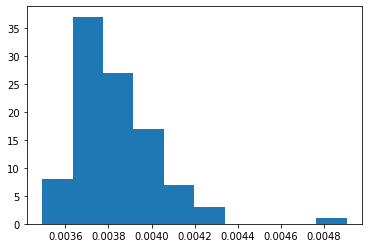

In [12]:
#create a normalized taxonomy embedding for a species aware classifier
print( len ( [ l for l in p.tree.get_leaves() ]))
import time
leaves = [ l for l in p.tree.get_leaves() ]
import random

times =[]
for i in range(100):
    t = time.time()
    p.tree.get_distance(random.choice(leaves).name,random.choice(leaves).name, topology_only=True)
    times.append(time.time()-t)
plt.hist(times)
print( np.mean(times)*(2290**2 / 2 - 2290) / 60 )



In [75]:

import multiprocessing as mp
from functools import partial

pool = mp.Pool()
distances = [ (l1.name,l2.name ) for i,l1 in enumerate(p.tree.get_leaves()) for j,l2 in enumerate(p.tree.get_leaves()) if i < j  ]
indices = [ (i,j )   for i,l1 in enumerate(p.tree.get_leaves()) for j,l2 in enumerate(p.tree.get_leaves()) if i < j  ]

def treedist( ltuple , tree):
    return tree.get_distance( ltuple[0] , ltuple[1], topology_only = True)

nleaves = len([ l for l in p.tree.get_leaves() ] )
treedist_load = partial( treedist , tree= p.tree )
res = pool.map_async(   treedist_load , distances ).get()


OSError: [Errno 12] Cannot allocate memory

In [77]:
taxmat = np.zeros( (nleaves, nleaves) )
for i,index in enumerate(indices):
    taxmat[index] = res[i]
taxmat+=taxmat.T

print(taxmat)
plt.hist(taxmat.ravel())
plt.show()
with open( 'taxkernel.pkl' ,'wb')as taxkernelout:
    taxkernelout.write(pickle.dumps(distances))
#project down with mds

NameError: name 'nleaves' is not defined

In [14]:
from sklearn.manifold import MDS
#create taxonomy projection
mds = MDS( n_components = 2 )
taxembed = mds.fit_transform(taxmat)
with open( 'taxproj.pkl' , 'wb') as taxprojout:
    taxprojout.write( pickle.dumps(taxembed))

NameError: name 'taxmat' is not defined

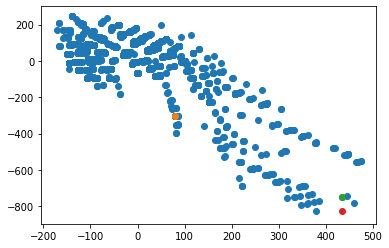

In [16]:
with open( 'taxproj.pkl' , 'rb' ) as taxprojin :
    taxembed = pickle.loads( taxprojin.read())
    
#use the profiler trimmed ncbi tree to generate an index 
taxindex = {int( n.name ) : i for i,n in enumerate( p.tree.get_leaves() ) }

plt.scatter( taxembed[:,0], taxembed[:,1]  )
#where is arabidopsis
plt.scatter( taxembed[taxindex[3702],0] , taxembed[taxindex[3702],1])
#where is human
plt.scatter( taxembed[taxindex[9606],0] , taxembed[taxindex[9606],1])
#where is chimp
plt.scatter( taxembed[taxindex[9606],0] , taxembed[taxindex[9598],1])
plt.show()
#ok... this more or less works


In [ ]:
from sklearn.preprocessing import RobustScaler , MinMaxScaler
rs = MinMaxScaler()
taxembedscaled = rs.fit_transform( taxembed )
plt.scatter( taxembedscaled[:,0], taxembedscaled[:,1]  )
plt.show()

In [ ]:
embedmat_scaled = rs.fit_transform( embedmat )


In [274]:
from sklearn.cluster import AffinityPropagation

def fam2hogid(fam_id):
    """
    For use with OMA HOGs
    Get hog id given fam
    :param fam_id: fam
    :return: hog id
    """
    hog_id = "HOG:" + (7-len(str(fam_id))) * '0' + str(fam_id)
    return hog_id

def hogid2fam(hog_id):
    """
    For use with OMA HOGs
    Get hog id given fam
    :param fam_id: fam
    :return: hog id
    """
    fam_id = int(hog_id.split(':')[1])
    return fam_id

def id2GO(intID):
    return 'GO:{:07d}'.format(intID)


def profiler_naive( qhog , p , gaf , c , nannot , hogs,  k = 10 , verbose = True  ):
    
    #use jaccard and IC to weigh all returned GO terms
    
    res = p.hog_query(fam_id = qhog , k = k )
    
    #grab entries from hogs
    hashes =  p.pull_hashes(res+[qhog])
    jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in res }
    members =  { r : [m for m in hogs[int(r)] if m in gaf ] for r in res  }
    godict = {  m + '_' + str(go) :{ 'fam':r , 'GO':go , 'Jaccard': jaccards[r] } for r in res for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
    godf = pd.DataFrame.from_dict( godict , orient = 'index')
    
    ICs = { go:np.log( nannot/c[go]) for go in godf.GO.unique() if go in c }
    godf['IC'] = godf.GO.map(ICs)
    
    
    #calculate the jaccards relative to the query
    
    godf['jaccard'] = godf.fam.map(jaccards)     
    #max jaccard * IC
    
    preddict = { go:{'max_jaccard':godf[godf.GO == go].jaccard.max() , 'IC':ICs[go]  } for go in godf.GO.unique() if go in ICs }
    predDF = pd.DataFrame.from_dict( preddict , orient = 'index')
       
    #awesome master super scoring function goes here
    predDF['score'] =  predDF.IC.min() * predDF.max_jaccard / predDF.IC
    #predDF['name'] = predDF.index.map(lambda go : obo[ id2GO(go)].name  )
    
    #consequences be damned...
    return predDF


def embedding_kd_ap(qhog,  p, kdtree, embedmat , index , reverse_index , nannot, c , k  , nsuggestions , hogs):
    
    #use kdtree of go term embedding and profiler
    #centroids of annotation clusters of all hogs returned are used to suggest k terms each
    #each cluster gets a jaccard score.
    #each annotation suggested gets distance from centroid. jaccard and IC
    
    res = p.hog_query(fam_id = qhog , k = k )
    #grab entries from hogs leaving qhog in there
    members =  { r : [m for m in hogs[int(r)] if m in gaf ] for r in res  }
    godict = {  m + '_' + str(go) :{ 'fam':r , 'GO':go } for r in res for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
    godf = pd.DataFrame.from_dict( godict , orient = 'index')
    GO_embedding = [index[go] for go in godf.GO.unique() if go in index]
    
    terms = np.array( godf.GO.unique() )
    
    
    #print(list( GO_embedding.values()))
    #calculate the jaccards relative to the query
    
    hashes =  p.pull_hashes(res+[qhog])
    jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in res }
    godf['jaccard'] = godf.fam.map(jaccards)
    #AP into clusters
    govecs = embedmat[GO_embedding,:]
    af = AffinityPropagation().fit(np.vstack( govecs ) )
    #take cluster centroids
    #k suggestions per cluster centroid
    
    suggestions ={}
    for i,clustercenter in enumerate(af.cluster_centers_):
        dis,idx = tree.query( clustercenter.reshape(1, -1) , k=nsuggestions)
        suggestions.update( { reverse_index[matrow] : { 'distance': dis[0][j] , 'cluster':i, 'jaccard':0 , 'nterms':0  }  for j,matrow in enumerate(list(idx[0])) } )
        
        #use embedding kdtree to find all close terms to cluster centroids
    predDF = pd.DataFrame.from_dict(suggestions , orient = 'index')    
    #precomput a numpy array and set the series in one go.
    jaccards = np.zeros( (len(predDF),1))
    nterms = np.zeros( (len(predDF),1))
    labels = np.array( predDF.cluster )
    
    for l in np.unique(af.labels_):
        #each label corresponds to a set of annotations in coevolving profiles        
        subterms = terms[ np.where(af.labels_ == l ) ]
        subdf = godf[godf.GO.isin(subterms)]
        jaccards[np.where(labels == l )] = subdf.jaccard.max()
        nterms[np.where(labels == l )] = len(subdf)
    predDF.jaccard = jaccards
    predDF.nterms = nterms
    ICs = { go:np.log( nannot/c[go]) for go in godf.GO.unique() if go in c }
    predDF['IC'] = predDF.index.map(ICs)
    
    #awesome super scoring function goes here. maybe give the suggestions a bit less weight
    #predictions farther from the centroid get less weight
    #coev score influences the pred as well
    
    predDF['score'] =  predDF.jaccard * predDF.nterms * predDF.IC.min() * predDF.distance.min() / ( predDF.nterms.max() * predDF.IC  * predDF.distance )
    predDF['name'] = predDF.index.map(lambda go : obo[ id2GO(go)].name )
    
    #consequences be damned...
    
    return predDF



In [275]:
#generate predictions with profiler naive
fams = list(targets.fam)
print(len(fams))
nannot = sum(c.values())
print(nannot)
'''for h in fams[0:10]:
    print('query:' +str(h) )
    print(profiler_naive( h , p , gaf , c , nannot , hogs, k= 10  ))
    
'''#generate predictions with profiler and go embedding
for h in fams[0:10]:
    print('query:' +str(h) )
    print(embedding_kd_ap( h ,  p, tree, embedmat , index , reverse_index , nannot, c,  10   , 10  , hogs))


83525
11603854834
query:472976
           distance  cluster   jaccard   nterms         IC  score  \
41        28.460133       19  0.523438    500.0        NaN    NaN   
149        9.326344       28  1.000000    413.0        NaN    NaN   
226       10.925283       16  0.539062   1922.0        NaN    NaN   
1653      19.840259        9  0.515625    419.0        NaN    NaN   
1778      31.944899       22  0.527344     27.0        NaN    NaN   
1818      10.103156       26  1.000000    537.0        NaN    NaN   
1958      99.445250        6  0.539062    120.0        NaN    NaN   
2253       2.906660       23  1.000000   2081.0        NaN    NaN   
2262      52.794251       17  0.523438    129.0        NaN    NaN   
2440      35.341349       22  0.527344     27.0        NaN    NaN   
3407      16.332218       22  0.527344     27.0        NaN    NaN   
3674     178.610037        8  0.531250    316.0   3.700490    0.0   
3724      59.983533       17  0.523438    129.0        NaN    NaN   
377

KeyboardInterrupt: 

In [383]:
###### start machine learning profiler based function prediction here #####
#fit distribution params to jaccards and annot vecs?
#pull in terms in the embedding and use them as suggestions

def gengovec( qseqdfs , p ,  gaf , c , taxembed , embedmat , index  , taxindex , specdict , hogs, visdist  , k , batchsize = 10):
    nannot = sum(c.values())
    #prob a good idea to generate a bunch of these and fit a normalizer on the data.
    #qseqdata is a generator of dataframes with columns = [ qseq , qhog ]
    #sequences are ordered by Hog number to avoid splitting them up
    govecs =[]
    ys=[]
    for qseqdata in qseqdfs:
        for qhog in qseqdata.hog.unique():
            #proceed by hog
            #use the profiler to get all coev HOGs
            res = p.hog_query(hog_id = qhog , k = k )
            if qhog in res:
                res.remove( qhog )
            hashes =  p.pull_hashes(res+[qhog])
            jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in res }
            print(res)
  
            members =  { r : [ m for m in hogs[int(r)] if m in gaf ] for r in res  }
            godict = {  m + '_' + str(go) :{ 'fam':r , 'GO':go , 'Tax':taxindex[specdict[m[0:5]]] } for r in res for m in members[r] for go in get_ancestors( gaf[m] , obo )  }
            if len(godict)>0:
                hashes =  p.pull_hashes(res+[qhog])
                jaccards = { r:hashes[r].jaccard(hashes[qhog]) for r in res }
                qhmembers = [ m for m in p.db_obj.iter_members_of_hog_id(qhog) if m.omaid in gaf]
                #if no annotations then just use 'biological process' as annotation
                #calculate Hog annotation centroid
                qHOGgo =  [ embedmat[ index[go] ,:]  for m in qhmembers for go in gaf[m.omaid] if go in index]
                
                if len(qHOGgo) == 0 :
                    #if no annotations then just use 'biological process' as annotation
                    qHOGavg = embedmat[ index[8150] ,: ]
                    qHOGstdv = [0,0,0]
                else:
                    #use embbedmat here

                    qHOGavg = np.mean( np.vstack(qHOGgo))
                    qHOGstdv = np.std( np.vstack(qHOGgo))

                godf = pd.DataFrame.from_dict( godict , orient = 'index')

                GO_embedding = { go:embedmat[ index[go], : ] for go in godf.GO.unique() }

                godf['GOembed'] = godf.GO.map(GO_embedding)
                counts = { go:len(godf[godf.GO==go]) for go in godf.GO.unique() }
                Freqs = { go:counts[go]/len(godf) for go in godf.GO.unique() }
                ICs = { go:np.log( nannot/c[go]) for go in godf.GO.unique() }
                Tax_embedding = { genome:taxembed[genome,:] for genome in godf.Tax.unique() }
                
                godf['jaccard'] = godf.fam.map(jaccards)
                godf['IC'] = godf.GO.map(ICs)
                godf['TaxEmbed'] = godf.Tax.map( Tax_embedding )
                
                
                GOembedavg = np.mean( np.vstack(godf.GOembed) ) 
                GOembedstd = np.std( np.vstack(godf.GOembed) )
                
                ICavg = np.mean( godf.IC )
                ICstdv = np.std( godf.IC )

                
                if visdist:
                    plt.title('Jaccard')
                    plt.hist(godf.jaccard)
                    plt.show()

                    plt.title('IC')
                    plt.hist(list(ICs.values()))
                    plt.show()
                    
                    

                for go in godf.GO.unique():
                    sub = godf[ godf.GO == go ]
                    taxspread = np.std(np.vstack(sub.Tax))
                    taxcentroid = np.mean(np.vstack(sub.Tax))
                    
                    #predict the application of each 
                    
                    for seq in qseqdata[qseqdata.hog == qhog ].index:
                    #for each go for each qseq    
                        seqTaxEmbed = taxembed[ taxindex[specdict[seq[0:5]]] , :  ]
                        #min taxonomic distance at which the annotation being tested is found
                        
                        taxdists = np.vstack(sub.TaxEmbed.map( lambda x: np.linalg.norm(x-seqTaxEmbed) ))
                        
                        if visdist:
                            plt.title('taxdist')
                            plt.hist(taxdists)
                            plt.show()

                        taxdifference = np.vstack(sub.TaxEmbed.map( lambda x: x-seqTaxEmbed) )
                        
                        taxdifferencespread = np.std(np.vstack(sub.Tax))
                        taxdifferencecentroid = np.mean(np.vstack(sub.Tax))
                        #generate a vec
                        #infomation content of proposed term
                        #todo: max IC, min IC

                        #avg IC of returned results
                        #stdv IC of returned results

                        #todo: max count, min count

                        #avg Count of annotation in results
                        #stdv Count of annotations in results
                        #Freq of term proposed

                        #Avg embedding of returned results
                        #stdv embedding of returned results

                        #Avg embedding of qhog annotations
                        #stdv embedding of qhog annotations

                        #max jaccard of HOG w annotation against qhog
                        #max jaccard across returned results
                        #mean jaccard across returned results
                        #stdv of jaccard across returned results
                        
                        
                        
                        govec = np.array( [ ICs[go] ,  ICavg , ICstdv , len(godf) , len(sub) ,  sub.jaccard.max() , godf.jaccard.mean() , godf.jaccard.std(), godf.jaccard.max(), godf.jaccard.min(), np.amin(taxdists)  ] )
                        govec = np.hstack([govec, seqTaxEmbed , GOembedavg , GOembedstd , GO_embedding[go] , qHOGavg, qHOGstdv , taxspread, taxcentroid , taxdifferencespread , taxdifferencecentroid])
                        
                        
                        
                        #does the prot have this annotation?
                        if go in gaf[seq] :
                            y = [1]
                        else:
                            y =[0]
                            
                        govecs.append(govec)
                        ys.append(y)
                        if len(govecs)> batchsize:
                            yield ( {'govec':np.vstack(govecs)} , {'y':np.vstack(ys)} )
                            ys =[]
                            govecs=[]

In [384]:
#generate a bunch of samples and fit robust scaler 
from sklearn.preprocessing import RobustScaler
RS = RobustScaler()

#pick random hogs with annotations
test = gengovec( hogiterator,  p ,  gaf , c , taxembed , embedmat , index  , taxindex , specdict , hogs,  False , 10  )
print(next(test))

#fit scaler

['360352', '359515', '359956', '360798', '360339', '359880', '360723', '360640', '360002', '359628']
({'govec': array([[ 6.65976692e+00,  8.96618557e+00,  3.39193883e+00,
         3.99900000e+03,  3.20000000e+01,  1.00000000e+00,
         9.96895708e-01,  9.36888484e-03,  1.00000000e+00,
         9.60937500e-01,  0.00000000e+00,  3.79584096e+02,
        -4.49335693e+02,  7.54292107e+00,  4.57255516e+01,
         3.32105217e+01, -3.60193748e+01, -3.66783791e+01,
         3.59197998e+01,  4.30304604e+01,  7.33510132e+01,
        -7.50622559e+01, -7.63483505e+01,  7.15773468e+01,
         7.15429459e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  6.99302107e+00,  1.92918750e+03,
         6.99302107e+00,  1.92918750e+03],
       [ 6.65976692e+00,  8.96618557e+00,  3.39193883e+00,
         3.99900000e+03,  3.20000000e+01,  1.00000000e+00,
         9.96895708e-01,  9.36888484e-03,  1.00000000e+00,
         9.60937500e-01,  0.00000000e+00,  3.11064251e+02,
        -4.97705238

In [ ]:
for i in range(10):
    t0 = time.time()
    print(next(test))

    
    print( time.time() - t0)

In [388]:
#use this net for predicting binary yes or no for each go term in a set given a set of inputs
import numpy as np
from keras.optimizers import *
from keras.layers import *
from keras.callbacks import *
from keras.models import load_model
import datetime
import keras
global max_epochs
from keras.models import Model
from keras.layers import Flatten, Input, Dense

from keras.backend import tensorflow_backend as K
epsilon = K.epsilon()
stamp = datetime.datetime.now().strftime('%m_%d_%Y_%H_%M_%S_%f')

import tensorflow as tf


################################################################################
dirlocal = './'
dataset = 'full' # 'sample' or 'full'

modelfile = 'model-' + str(stamp) + '.h5'

densedim = 30
layers = 10 

govec_test = next( test )
print(govec_test)

a = Input(shape= ( govec_test[0]['govec'].shape[1] , )   , name='govec' ) 


for i in range( layers):
    if i == 0:
        b = Dense(densedim)(a)
        layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones')
        b = layer(b)

    else:
        #add batch reg
        #add dropout
        b = Dense(densedim)(b)
        layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones')
        b = layer(b)

layer = Dense(1,activation = 'sigmoid' , name = 'y')
final = layer(b)
model = Model(inputs=a, outputs=final)
o = keras.optimizers.Adadelta(lr=.025, rho=0.95)
model.compile( optimizer=o, loss= 'binary_crossentropy' , metrics=['mae'])

max_len = 3000
mc = ModelCheckpoint(modelfile, monitor = 'loss', mode = 'min', verbose = 1, save_best_only = True)
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose = 2, patience = 100)
####change this
history = model.fit_generator( test  ,verbose = 2 , steps_per_epoch= 100, epochs = 100000  , callbacks=[es, mc])

({'govec': array([[ 5.10521213e+00,  6.50893762e+00,  2.36557691e+00,
         1.16740000e+04,  7.60000000e+01,  1.00000000e+00,
         9.60238832e-01,  2.90129808e-02,  1.00000000e+00,
         9.14062500e-01,  0.00000000e+00, -6.13784543e+01,
         9.34980987e+01,  9.99357796e+00,  5.76954079e+01,
         5.97931938e+01, -5.47213631e+01, -5.48932915e+01,
         6.11504631e+01,  5.93199806e+01,  7.33510132e+01,
        -7.50622559e+01, -7.63483505e+01,  7.15773468e+01,
         7.15429459e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.46233961e+01,  1.47363158e+03,
         2.46233961e+01,  1.47363158e+03],
       [ 5.10521213e+00,  6.50893762e+00,  2.36557691e+00,
         1.16740000e+04,  7.60000000e+01,  1.00000000e+00,
         9.60238832e-01,  2.90129808e-02,  1.00000000e+00,
         9.14062500e-01,  0.00000000e+00, -6.13690740e+01,
         9.35063472e+01,  9.99357796e+00,  5.76954079e+01,
         5.97931938e+01, -5.47213631e+01, -5.48932915e+01,
  

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/keras/engine/network.py:180: UserWarning: Model inputs must come from `keras.layers.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to your model was not an Input tensor, it was generated by layer batch_normalization_181.
Note that input tensors are instantiated via `tensor = keras.layers.Input(shape)`.
The tensor that caused the issue was: batch_normalization_181/cond/Merge:0
  str(x.name))


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("govec_19:0", shape=(?, 32), dtype=float32) at layer "govec". The following previous layers were accessed without issue: []

In [ ]:

# jaccard , IC , depth , vec embed , avg of GO terms embed , variance of go terms embed,  num go terms returned ,  profile DB type (one hot for each DB made)

#use batch normalization to scale input values

# possible input: difference and intersection profile vector with all hogs that have the term
#would have to iron out the profile storage issue before this works


inputlayer = Input( )



